# Test pretrained model(s)

ATTENTION!!! Run the qubvel pretrained Network in a separate conda environment with:
- torch==1.1.0
- python >=3.7,<3.8
- for details read qubvel_requirements.txt

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import torchvision
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib.pyplot as plt
from Networks import Five_UNet
from torchvision import transforms
from PIL import Image


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

torch.Size([512, 512, 3])
torch.Size([3, 512, 512, 10])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([10, 3, 512, 512])


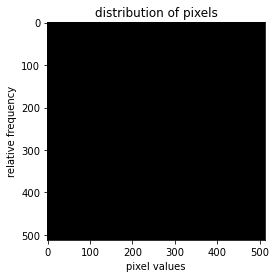

In [2]:
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")

DZK = []

for root, path, filename in os.walk(os.path.join(data_path, "td_DZK", "IMG/")):
    for i in filename:
        if i.endswith(".png"):
            to_tensor = transforms.ToTensor()
            
            with Image.open(root + i) as img:
                img = to_tensor(img)
                DZK.append(img)

# plot the pixel values
#img_np = np.array(DZK[3])
#plt.hist(img_np.ravel(), bins=50, density=True)
#plt.xlabel("pixel values")
#plt.ylabel("relative frequency")
#plt.title("distribution of pixels")                

test = DZK[4].permute(1, 2, 0)
print(test.shape)
plt.imshow(test)

# Calculate mean and std for normalisation
# (Channel, Height, Width, Batch)
imgs = torch.stack(DZK, dim = 3)
print(imgs.shape)

mean = imgs.view(3, -1).mean(dim = 1)
std = imgs.view(3, -1).std(dim = 1)

# Reset DZK list
DZK = []

for root, path, filename in os.walk(os.path.join(data_path, "td_DZK", "IMG/")):
    for i in filename:
        if i.endswith(".png"):
            to_tensor = transforms.ToTensor()
            
            with Image.open(root + i) as img:
                img = to_tensor(img)
                DZK.append(img)
                print(img.shape)

# plot the pixel values
img_np = np.array(DZK[8])
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
                
# (Batch, Channel, Height, Width) format == nn.Conv2d()                
imgs = torch.stack(DZK, dim = 0)
print(imgs.shape)

## Chris custom 5 layer U-Net

In [3]:
# Chris' 5 layer U_Net
Five_UNet = Five_UNet()

print(sum(p.numel() for p in Five_UNet.parameters() if p.requires_grad == True))
#print(Five_UNet)

23496066


### Mateuszbuda classic U_Net

In [4]:
# Inspect U-Net (not native torchvision, but torch.hub)
brain_UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                  in_channels = 3, out_channels = 1, init_features = 32, pretrained=True)

print(sum(p.numel() for p in brain_UNet.parameters() if p.requires_grad == True))
#print(brain_UNet)

# Pass the image through
img_t = DZK[8]
prediction = brain_UNet(img_t.unsqueeze(0))

print(prediction)

predicted_class = prediction.detach().numpy()
print(np.argmax(predicted_class))

Using cache found in /home/chris/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/chris/.cache/torch/checkpoints/unet-e012d006.pt


7763041
tensor([[[[5.5781e-06, 4.7937e-06, 8.4292e-06,  ..., 1.6734e-06,
           7.2109e-07, 3.1599e-06],
          [6.2059e-06, 3.3786e-06, 9.0324e-06,  ..., 5.2748e-07,
           2.6459e-07, 1.2898e-06],
          [6.4884e-06, 2.5493e-05, 6.4062e-06,  ..., 2.4354e-07,
           1.1083e-07, 4.5566e-07],
          ...,
          [7.6218e-06, 1.5540e-05, 2.2886e-05,  ..., 1.0981e-06,
           3.2117e-07, 5.2226e-07],
          [1.3021e-05, 1.9110e-05, 1.3582e-05,  ..., 1.5786e-06,
           3.0391e-07, 1.0297e-06],
          [4.3103e-06, 4.2378e-06, 4.0916e-06,  ..., 2.5784e-06,
           1.7760e-06, 2.6084e-06]]]], grad_fn=<SigmoidBackward>)
37451


### Qubvel OpenCities U-Net

In [5]:
effb1_UNet = smp.Unet(encoder_name='efficientnet-b1', encoder_depth=5, encoder_weights=None, decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation="softmax", aux_params=None)

qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
effb1_UNet.load_state_dict(qubvel_weights["state_dict"])

print(sum(p.numel() for p in effb1_UNet.parameters() if p.requires_grad == True))

8757105


In [6]:
print(type(effb1_UNet))

<class 'segmentation_models_pytorch.unet.model.Unet'>


In [7]:
effb1_UNet.eval()

# Pass the image through
img_t = DZK[8]
prediction = effb1_UNet(img_t.unsqueeze(0))

print(prediction)

predicted_class = prediction.detach().numpy()
print(np.argmax(predicted_class))

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], grad_fn=<SoftmaxBackward>)
0


/home/chris/miniconda3/envs/qubvel3.7_cpu/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
